In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astromodal.config import load_config
from tqdm import tqdm
import polars as pl
import random
from pathlib import Path
from astromodal.datasets.datacubes import load_datacube_files

In [3]:
config = load_config("/home/schwarz/projetoFM/config.yaml")

hdd_folder = config['hdd_folder']

hddfolder = Path(config["hdd_folder"]) / "image_latents" 

In [4]:
file = config['datacubes_paths'].replace('*', 'STRIPE82-0002')

import polars as pl

header = pl.read_parquet(file, n_rows=0)
columns = [col for col in header.columns if 'desi' in col] + ["id", "mag_psf_r"]

In [5]:
train_files, val_files = load_datacube_files(config['datacubes_paths'], train_val_split=0.9, nfiles_subsample=800)

[info] - Found 2444 datacube files
[info] - Subsampled to 800 files
[info] - Training files: 720
[info] - Validation files: 80


In [6]:
train_df = None

for f in tqdm(train_files, desc="Loading train files"):
    try:
        df = pl.read_parquet(f, columns=columns, use_pyarrow=True)
        df = df.filter(pl.col(columns[0]).is_not_null())
        
        df = df.filter(pl.col("mag_psf_r") < 21)
        
        
        if df.height == 0:
            continue

        train_df = df if train_df is None else pl.concat([train_df, df], how="vertical", rechunk=False)
    except Exception as e:
        pass


Loading train files: 100%|██████████| 720/720 [01:40<00:00,  7.14it/s]


In [12]:
val_df = None

for f in tqdm(val_files, desc="Loading val files"):
    try:
        df = pl.read_parquet(f, columns=columns, use_pyarrow=True)
        df = df.filter(pl.col(columns[0]).is_not_null())
        
        df = df.filter(pl.col("mag_psf_r") < 21)
        
        
        if df.height == 0:
            continue

        val_df = df if val_df is None else pl.concat([val_df, df], how="vertical", rechunk=False)
    except Exception as e:
        pass

Loading val files: 100%|██████████| 80/80 [00:25<00:00,  3.19it/s]


In [14]:
train_df = train_df.filter(pl.col("desi_wave_b").is_not_null())
val_df = val_df.filter(pl.col("desi_wave_b").is_not_null())

In [ ]:
from astromodal.specifics.desi_scaler import fit_standard_scaler_1d_from_desi_df

scaler = fit_standard_scaler_1d_from_desi_df(train_df)

In [16]:
scaler_path = Path(config['models_folder']) / "scalers" / "desi_flux_standard_scaler.npz"
scaler.save(scaler_path)

In [39]:
from torch.utils.data import DataLoader
from pathlib import Path

from astromodal.datasets.desi_spectra import DesiStitchedFluxOnlyDataset, desi_collate_pad_flux_only

scaler_path = Path(config["models_folder"]) / "scalers" / "desi_flux_standard_scaler.npz"

ds_train = DesiStitchedFluxOnlyDataset(
    train_df,
    scaler_path=scaler_path,
)

dl_train = DataLoader(
    ds_train,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=desi_collate_pad_flux_only,  # same collate
)

ds_val = DesiStitchedFluxOnlyDataset(
    val_df,
    scaler_path=scaler_path,
)

dl_val = DataLoader(
    ds_val,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=desi_collate_pad_flux_only,
)



In [23]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from astromodal.config import load_config
from tqdm import tqdm
import polars as pl
from pathlib import Path
from astromodal.datasets.datacubes import load_datacube_files

from astromodal.models.spectral_autoencoder import SpectraAutoEncoder
from astromodal.datasets.desi_spectra import DesiStitchedFluxOnlyDataset, desi_collate_pad_flux_only
from torch.utils.data import DataLoader
import torch


# =============================================================================
# CONFIG (set what you need here)
# =============================================================================
CONFIG_PATH = "/home/schwarz/projetoFM/config.yaml"
STRIPE = "STRIPE82-0002"          # used to probe schema (columns)
NFILES_SUBSAMPLE = 800
TRAIN_VAL_SPLIT = 0.9

MAG_R_MAX = 21
BATCH_SIZE = 64
NUM_WORKERS = 4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LATENT_DIM = 16
BASE_CHANNELS = 64
NUM_DOWN = 4
KERNEL_SIZE = 5
LR = 3e-4
WEIGHT_DECAY = 1e-3
EPOCHS = 10

In [24]:
model = SpectraAutoEncoder(
    latent_dim=LATENT_DIM,
    base_channels=BASE_CHANNELS,
    num_down=NUM_DOWN,
    k=KERNEL_SIZE,
).to(DEVICE)

In [37]:
model.save(Path(config["models_folder"]) / "spectra_autoencoder_desi.pth")

In [33]:
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Train
for epoch in range(EPOCHS):
    tr = model.train_epoch(dl_train, opt, DEVICE)
    va = model.validate(dl_val, DEVICE)
    print(f"Epoch {epoch:02d} | train={tr:.6f} | val={va:.6f}")

Training:   0%|          | 0/2827 [00:00<?, ?it/s]

Epoch 00 | train=0.000718 | val=0.000900


Epoch 01 | train=0.000448 | val=0.000500


Epoch 02 | train=0.000367 | val=0.000474


Epoch 03 | train=0.000286 | val=0.000354


Epoch 04 | train=0.000215 | val=0.000242


Epoch 05 | train=0.000268 | val=0.000888


Epoch 06 | train=0.000191 | val=0.000085


Epoch 07 | train=0.000164 | val=0.000085


KeyboardInterrupt: 

In [40]:
from pathlib import Path
from astromodal.models.scaler1d import StandardScaler1D

# whatever path you saved the scaler to
SCALER_PATH = Path(config["models_folder"]) / "scalers" / "desi_flux_standard_scaler.npz"

scaler = StandardScaler1D.load(SCALER_PATH)  # from my previous message

In [34]:
from astromodal.datasets.desi_spectra import stitch_desi_arms
import torch
import numpy as np

@torch.no_grad()
def run_one_object_ae_flux_only_with_scaler(row, model, scaler, device="cuda"):
    # --------------------------------------------------
    # 1) stitch DESI arms
    # --------------------------------------------------
    w, f, iv, mask = stitch_desi_arms(
        row["desi_wave_b"], row["desi_flux_b"], row["desi_ivar_b"],
        row["desi_wave_r"], row["desi_flux_r"], row["desi_ivar_r"],
        row["desi_wave_z"], row["desi_flux_z"], row["desi_ivar_z"],
    )
    if f.size == 0:
        return None

    mask = mask.astype(bool)

    # --------------------------------------------------
    # 2) GLOBAL normalization via scaler (same as dataset)
    # --------------------------------------------------
    f_norm = scaler.transform_x(f).astype(np.float32)

    # --------------------------------------------------
    # 3) model expects [B, L, 1]
    # --------------------------------------------------
    x_t = torch.from_numpy(f_norm[:, None]).unsqueeze(0).to(device)  # [1,L,1]

    # --------------------------------------------------
    # 4) encode / decode
    # --------------------------------------------------
    z = model.encode(x_t)  # [1, latent_dim, T]
    x_hat_norm = model.decode(z, L_out=x_t.shape[1])  # [1,L,1]
    f_hat_norm = x_hat_norm.squeeze(0).squeeze(-1).detach().cpu().numpy()

    # --------------------------------------------------
    # 5) denormalize using scaler inverse
    # --------------------------------------------------
    f_hat = scaler.inverse_transform_x(f_hat_norm)

    return {
        "wave": w,
        "flux": f,
        "flux_hat": f_hat,
        "mask": mask,
        "latent": z.squeeze(0).cpu(),
        "scaler_mean": scaler.mean,
        "scaler_std": scaler.std,
        "transform": scaler.transform,
        "asinh_scale": scaler.asinh_scale,
    }

/tmp/ipykernel_2433327/1342788542.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


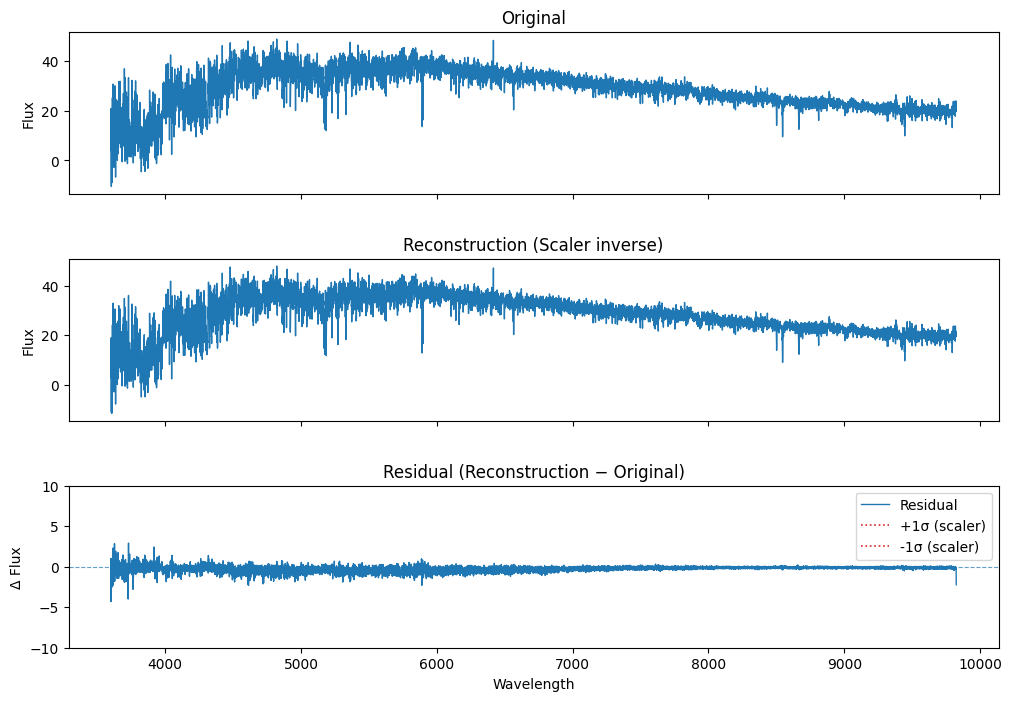

In [45]:
import random
import matplotlib.pyplot as plt
import numpy as np

def scaler_sigma_in_flux(scaler):
    """
    Return the 1-sigma scale in physical flux units
    corresponding to +1 in normalized space.
    """
    # delta in normalized space
    x0 = np.array([0.0])
    x1 = np.array([1.0])

    f0 = scaler.inverse_transform_x(x0)[0]
    f1 = scaler.inverse_transform_x(x1)[0]
    return abs(f1 - f0)


row = train_df.row(random.randint(0, train_df.height - 1), named=True)
out = run_one_object_ae_flux_only_with_scaler(row, model, scaler, device="cuda")

if out is not None:
    w = out["wave"]
    f = out["flux"]
    f_hat = out["flux_hat"]
    m = out["mask"]

    resid = f_hat - f

    # ---------------------------------
    # compute sigma in flux units
    # ---------------------------------
    sigma_flux = scaler_sigma_in_flux(scaler)

    fig, axes = plt.subplots(
        3, 1,
        figsize=(12, 8),
        sharex=True,
        gridspec_kw={"hspace": 0.4},
    )

    # -------------------
    # Original
    # -------------------
    axes[0].plot(w[m], f[m], lw=1)
    axes[0].set_ylabel("Flux")
    axes[0].set_title("Original")

    # -------------------
    # Reconstruction
    # -------------------
    axes[1].plot(w[m], f_hat[m], lw=1)
    axes[1].set_ylabel("Flux")
    axes[1].set_title("Reconstruction (Scaler inverse)")

    # -------------------
    # Residual + sigma
    # -------------------
    axes[2].plot(w[m], resid[m], lw=1, label="Residual")
    axes[2].axhline(0.0, ls="--", lw=0.8, alpha=0.7)

    axes[2].axhline(+sigma_flux, ls=":", lw=1.2, color="tab:red", label="+1σ (scaler)")
    axes[2].axhline(-sigma_flux, ls=":", lw=1.2, color="tab:red", label="-1σ (scaler)")

    axes[2].set_ylabel("Δ Flux")
    axes[2].set_xlabel("Wavelength")
    axes[2].set_title("Residual (Reconstruction − Original)")
    
    # limit y to -10 to +10 sigma
    axes[2].set_ylim(-10, 10)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

In [47]:
# use the model to encode all train_df objects and save latents
latents_out = []

for row in tqdm(train_df.iter_rows(named=True), total=train_df.height, desc="Encoding train_df"):
    out = run_one_object_ae_flux_only_with_scaler(row, model, scaler, device="cuda")
    if out is not None:
        latents_out.append({
            "id": row["id"],
            "latent": out["latent"].cpu().numpy(),
        })
        
latents_df = pl.DataFrame(latents_out)

Encoding train_df: 100%|██████████| 180873/180873 [12:21<00:00, 243.93it/s]


In [48]:
CONFIG_PATH = "/home/schwarz/projetoFM/config.yaml"

# Must match the **previous latent-encoding script**
LATENTS_SUBFOLDER = "spectra_latents_desi"   # inside hdd_folder
LATENT_COL = "latent"
ID_COL = "id"

# AE latent info
LATENT_DIM = 16

# RVQ / tokenizer
PATCH_SIZE = 2
NUM_STAGES = 3
CODEBOOK_SIZE = 1024
DECAY = 0.99

# Training
BATCH_SIZE = 128
NUM_WORKERS = 4
EPOCHS = 20

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

OUT_NAME = "spectral_patch_rvq_desi.pth"

In [49]:
from astromodal.datasets.desi_spectra import LatentsPolarsDataset, collate_latents_pad_to_patch_multiple

ds_lat = LatentsPolarsDataset(
    latents_df,
    id_col=ID_COL,
    latent_col=LATENT_COL,
    latent_dim=LATENT_DIM,
    nested_layout="auto",
)

loader_lat = DataLoader(
    ds_lat,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=lambda batch: collate_latents_pad_to_patch_multiple(
        batch, patch_size=PATCH_SIZE
    ),
)

In [54]:
from astromodal.tokenizers.rvq import ResidualVQ
from astromodal.tokenizers.spectralrvq import SpectralPatchRVQ

P = PATCH_SIZE
C = LATENT_DIM
D = P * C

rvq = ResidualVQ(
    dim=D,
    num_stages=NUM_STAGES,
    codebook_size=CODEBOOK_SIZE,
    decay=DECAY,
).to(DEVICE)

tok = SpectralPatchRVQ(
    rvq=rvq,
    patch_size=P,
    channels=C,
).to(DEVICE)

# -------------------------------------------------------------------------
# Train (EMA-only)
# -------------------------------------------------------------------------
tok.train()
for epoch in range(EPOCHS):
    stats = tok.train_epoch(loader_lat, device=DEVICE, update_ema=True)
    print(f"Epoch {epoch:02d} | {stats}")


Epoch 00 | {'loss': 0.1797717254097199}
Epoch 01 | {'loss': 0.1640482792361919}
Epoch 02 | {'loss': 0.16097549432714744}
Epoch 03 | {'loss': 0.15953118417267026}
Epoch 04 | {'loss': 0.15872023551576112}
Epoch 05 | {'loss': 0.15821000261602503}
Epoch 06 | {'loss': 0.1578583772407981}
Epoch 07 | {'loss': 0.15759592185934693}
Epoch 08 | {'loss': 0.15740780623238598}
Epoch 09 | {'loss': 0.15726438847358556}
Epoch 10 | {'loss': 0.15712457074678254}
Epoch 11 | {'loss': 0.15702005394206928}
Epoch 12 | {'loss': 0.1569197191019902}
Epoch 13 | {'loss': 0.15684303734026736}
Epoch 14 | {'loss': 0.15677190557404233}
Epoch 15 | {'loss': 0.15671356014918605}
Epoch 16 | {'loss': 0.1566709880196196}
Epoch 17 | {'loss': 0.1566207306392145}
Epoch 18 | {'loss': 0.15659422397712058}
Epoch 19 | {'loss': 0.15656384084590527}


In [55]:

# -------------------------------------------------------------------------
# Save
# -------------------------------------------------------------------------
out_path = Path(config["models_folder"]) / OUT_NAME
tok.save(out_path)
print(f"Saved tokenizer to: {out_path}")

[info] - Saved SpectralPatchRVQ to /home/schwarz/projetoFM/outputs/spectral_patch_rvq_desi.pth
Saved tokenizer to: /home/schwarz/projetoFM/outputs/spectral_patch_rvq_desi.pth


In [52]:
import numpy as np
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def run_full_chain_and_plot_with_scaler(
    row,
    ae_model,
    tok_model,
    scaler,                 # <-- NEW
    device="cuda",
    *,
    plot=True,
    max_points=None,
):
    ae_model.eval().to(device)
    tok_model.eval().to(device)

    # -------------------------
    # 1) stitch
    # -------------------------
    w, f, iv, mask = stitch_desi_arms(
        row.get("desi_wave_b"), row.get("desi_flux_b"), row.get("desi_ivar_b"),
        row.get("desi_wave_r"), row.get("desi_flux_r"), row.get("desi_ivar_r"),
        row.get("desi_wave_z"), row.get("desi_flux_z"), row.get("desi_ivar_z"),
    )
    if f.size == 0:
        return None

    mask = mask.astype(bool)

    # optional plot downsample (keeps mask alignment)
    if max_points is not None and f.size > max_points:
        idx = np.linspace(0, f.size - 1, max_points).astype(int)
        w = w[idx]
        f = f[idx]
        mask = mask[idx]
        iv = iv[idx]

    # -------------------------
    # 2) normalize using SCALER (survey-level)
    # -------------------------
    # Important: scaler should have been trained on DESI flux values in the SAME units
    f_norm = scaler.transform_x(f).astype(np.float32)   # [L]

    x = torch.from_numpy(f_norm[:, None]).unsqueeze(0).to(device)  # [1,L,1]
    L = x.shape[1]

    # -------------------------
    # 3) AE encode/decode (normalized space)
    # -------------------------
    z_ae = ae_model.encode(x)                                # [1, C_lat, T]
    xhat_ae_norm = ae_model.decode(z_ae, L_out=L)            # [1, L, 1]
    fhat_ae_norm = xhat_ae_norm[0, :, 0].detach().cpu().numpy()

    # inverse scaler back to flux space
    fhat_ae = scaler.inverse_transform_x(fhat_ae_norm)

    # latent sequence for tokenizer: [B, T, C_lat]
    z_seq = z_ae.transpose(1, 2).contiguous()               # [1, T, C_lat]
    T = z_seq.shape[1]
    C_lat = z_seq.shape[2]

    if hasattr(tok_model, "channels") and int(tok_model.channels) != int(C_lat):
        raise ValueError(
            f"Tokenizer channels={tok_model.channels} but AE latent_dim={C_lat}. "
            f"Instantiate tok with channels=latent_dim."
        )

    # -------------------------
    # 4) Tokenizer encode/decode in latent space
    # -------------------------
    enc_tok = tok_model.encode(z_seq, update_ema=False)
    codes = enc_tok["codes"]              # [1, T_tok, R]
    T_tok = int(enc_tok["T"])
    L_lat = int(enc_tok["L"])             # should equal T (latent length)

    zq_seq = tok_model.decode(codes, L=L_lat)     # [1, L_lat, C_lat]
    zq_seq = zq_seq[:, :T, :]                     # [1, T, C_lat] match AE z length

    # -------------------------
    # 5) Decode tokenizer-quantized latents back to flux
    # -------------------------
    zq_ae = zq_seq.transpose(1, 2).contiguous()   # [1, C_lat, T]
    xhat_final_norm = ae_model.decode(zq_ae, L_out=L)  # [1, L, 1]
    fhat_final_norm = xhat_final_norm[0, :, 0].detach().cpu().numpy()

    # inverse scaler back to flux space
    fhat_final = scaler.inverse_transform_x(fhat_final_norm)

    # -------------------------
    # 6) residuals (flux units)
    # -------------------------
    resid_ae = fhat_ae - f
    resid_final = fhat_final - f
    resid_final_vs_ae = fhat_final - fhat_ae

    # -------------------------
    # 6b) residuals in sigma units (chi), using DESI ivar
    # chi = (fhat - f) / sigma_noise = (fhat - f) * sqrt(ivar)
    # -------------------------
    chi_ae = np.full_like(f, np.nan, dtype=np.float64)
    chi_final = np.full_like(f, np.nan, dtype=np.float64)
    chi_final_vs_ae = np.full_like(f, np.nan, dtype=np.float64)

    good = mask & np.isfinite(iv) & (iv > 0)
    if np.any(good):
        s = np.sqrt(iv[good])
        chi_ae[good] = resid_ae[good] * s
        chi_final[good] = resid_final[good] * s
        chi_final_vs_ae[good] = resid_final_vs_ae[good] * s

    out = {
        "wave": w,
        "mask": mask,
        "ivar": iv,
        "flux": f,
        "flux_hat_ae": fhat_ae,
        "flux_hat_final": fhat_final,
        "resid_ae_minus_orig": resid_ae,
        "resid_final_minus_orig": resid_final,
        "resid_final_minus_ae": resid_final_vs_ae,
        "chi_ae_minus_orig": chi_ae,
        "chi_final_minus_orig": chi_final,
        "chi_final_minus_ae": chi_final_vs_ae,
        "latent_ae_ct": z_ae[0].detach().cpu().numpy(),      # [C_lat, T]
        "latent_tok_tc": zq_seq[0].detach().cpu().numpy(),   # [T, C_lat]
        "codes": codes.detach().cpu(),                       # [1, T_tok, R]
    }

    # -------------------------
    # 7) plotting
    # -------------------------
    if plot:
        m = mask

        fig, axes = plt.subplots(
            5, 1, figsize=(12, 12), sharex=True,
            gridspec_kw={"hspace": 0.50}
        )

        axes[0].plot(w[m], f[m], lw=1)
        axes[0].set_ylabel("Flux")
        axes[0].set_title("Original (stitched)")

        axes[1].plot(w[m], fhat_ae[m], lw=1)
        axes[1].set_ylabel("Flux")
        axes[1].set_title("AE reconstruction (scaler inverse)")

        axes[2].plot(w[m], fhat_final[m], lw=1)
        axes[2].set_ylabel("Flux")
        axes[2].set_title("Final reconstruction (AE ∘ Tok ∘ AE) (scaler inverse)")

        axes[3].plot(w[m], resid_ae[m], lw=1, label="AE − Orig", alpha=0.5)
        axes[3].plot(w[m], resid_final_vs_ae[m], lw=1, label="Final − AE", alpha=0.5)
        axes[3].plot(w[m], resid_final[m], lw=1, label="Final − Orig", alpha=0.5)
        axes[3].axhline(0.0, ls="--", lw=0.8, alpha=0.7)
        axes[3].set_ylabel("Δ Flux")
        axes[3].set_title("Residuals (flux units)")
        axes[3].legend()

        axes[4].plot(w[good], chi_ae[good], lw=1, label="(AE − Orig) / σ", alpha=0.6)
        axes[4].plot(w[good], chi_final_vs_ae[good], lw=1, label="(Final − AE) / σ", alpha=0.6)
        axes[4].plot(w[good], chi_final[good], lw=1, label="(Final − Orig) / σ", alpha=0.6)
        axes[4].axhline(0.0, ls="--", lw=0.8, alpha=0.7)
        axes[4].axhline(+1.0, ls=":", lw=0.8, alpha=0.5)
        axes[4].axhline(-1.0, ls=":", lw=0.8, alpha=0.5)
        axes[4].axhline(+3.0, ls=":", lw=0.8, alpha=0.5)
        axes[4].axhline(-3.0, ls=":", lw=0.8, alpha=0.5)
        axes[4].set_ylabel("Residual (σ units)")
        axes[4].set_xlabel("Wavelength")
        axes[4].set_title("Residuals in sigma units (χ), using DESI ivar")
        axes[4].legend()

        plt.tight_layout()
        plt.show()

    return out

/tmp/ipykernel_2433327/3873832628.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


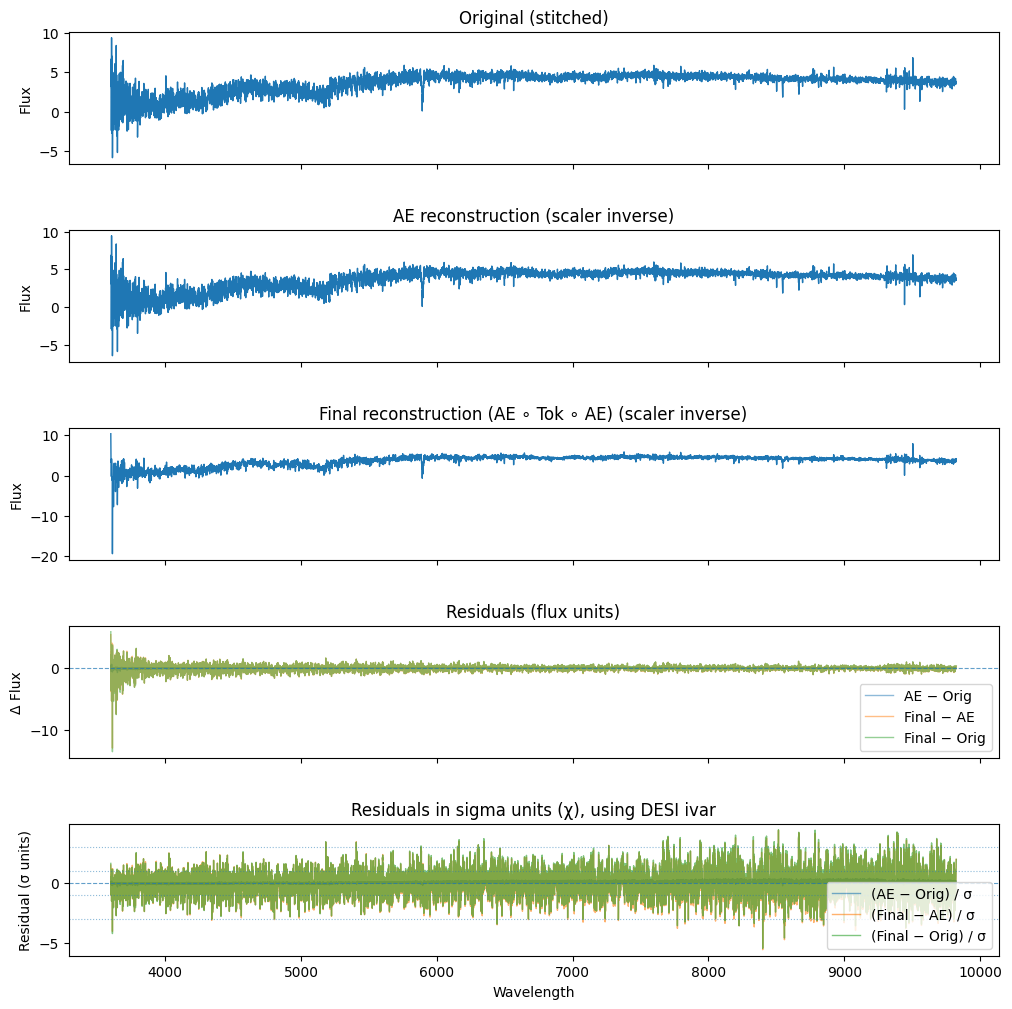

{'wave': array([3600.        , 3600.80004883, 3601.60009766, ..., 9822.40039062,
        9823.20019531, 9824.        ], shape=(7781,)),
 'mask': array([ True,  True,  True, ...,  True,  True,  True], shape=(7781,)),
 'ivar': array([ 0.07966411,  0.06901181,  0.07372426, ..., 22.48352051,
        28.1119957 , 28.97429466], shape=(7781,)),
 'flux': array([4.47995806, 3.66476345, 3.60240746, ..., 3.59351707, 3.85229301,
        3.63362026], shape=(7781,)),
 'flux_hat_ae': array([4.9632686 , 3.99777775, 3.44753495, ..., 3.63811573, 3.84071148,
        3.6320385 ], shape=(7781,)),
 'flux_hat_final': array([10.39535363,  5.61721398,  3.36807485, ...,  3.80705583,
         4.22163438,  4.00618259], shape=(7781,)),
 'resid_ae_minus_orig': array([ 0.48331054,  0.3330143 , -0.15487251, ...,  0.04459867,
        -0.01158154, -0.00158176], shape=(7781,)),
 'resid_final_minus_orig': array([ 5.91539557,  1.95245053, -0.2343326 , ...,  0.21353877,
         0.36934137,  0.37256233], shape=(7781,)),
 '

In [53]:
row = train_df.row(random.randint(0, train_df.height - 1), named=True)

run_full_chain_and_plot_with_scaler(
    ae_model=model,
    tok_model=tok,
    scaler=scaler,
    row=row,
    device="cuda",
)